In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from numpy import *
from numpy.fft import rfft, irfft
import numpy.random as rnd
import scipy.signal as sig

In [14]:
tlen = 3000 # seconds
srate = 1024 # Hertz
seglen = 9 # seconds

In [5]:
noise = TimeSeries(rnd.normal(size=tlen*srate), sample_rate=srate)

In [7]:
fnoise = rfft(noise)

In [25]:
# Mean-square in TD is just 1
mean(abs(noise)**2)

<Quantity 1.00067559>

In [74]:
# Mean-square in FD is Nsamples
mean(abs(fnoise)**2) / (tlen*srate)

1.0006750329829648

In [19]:
psd = noise.psd(seglen)

In [28]:
# Mean of PSD is 2 / samplerate
mean(psd.value) / (2./srate)

1.0006552891418563

In [63]:
freqs = arange(1+seglen*srate/2)/float(seglen)
desired_psd = 1 + (freqs/300.)**2
desired_psd[0] = 0.
gen_filter = sqrt(srate/2.)*sig.hann(seglen*srate)*roll(irfft(sqrt(desired_psd)), seglen*srate/2)

In [64]:
long_filter = gen_filter.copy()
long_filter.resize(len(noise))
shaped_noise1 = TimeSeries(irfft(abs(rfft(long_filter)) * fnoise), sample_rate = srate)
shaped_psd1 = shaped_noise1[4*srate:-4*srate].psd(seglen)

In [140]:
shaped_noise2 = TimeSeries(sig.convolve(noise, gen_filter, mode='same'), sample_rate = srate)
shaped_psd2 = shaped_noise2[4*srate:-4*srate].psd(seglen)

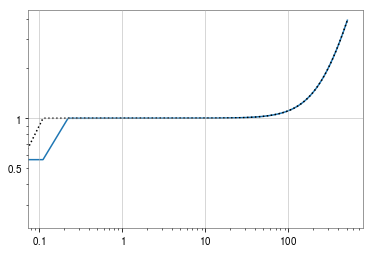

In [141]:
plt.loglog(freqs, abs(rfft(gen_filter))**2/(srate/2.))
plt.loglog(freqs, desired_psd, c='k', ls=':')

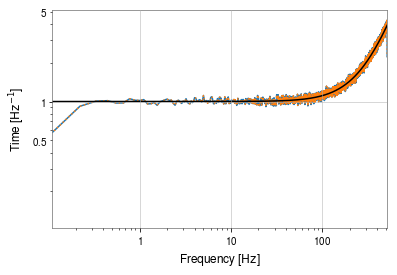

In [142]:
p1 = shaped_psd1.plot()
p1.gca().plot(shaped_psd2, ls=':')
plt.loglog(freqs, desired_psd, c='k')

Let's check the normalization of the whitening filter.

The inverse ASD should be multiplied by the sqrt(2 / sample_rate) in order to get the variance of the whitened time domain data to be one.

In [150]:
invasd = sqrt(2./srate)/sqrt(shaped_psd1)
invasd[0] = 0.
whitener = sig.hann(seglen*srate)*roll(irfft(invasd), seglen*srate/2)

In [151]:
wtest = TimeSeries(sig.convolve(shaped_noise2, whitener, mode='same')[8*srate:-8*srate],
                       sample_rate=srate)

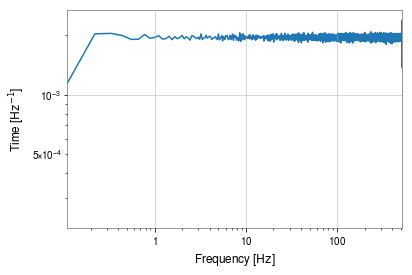

In [152]:
p1 = wtest.psd(seglen).plot()

In [153]:
mean(wtest.psd(seglen)) / (2./srate)

<Quantity 0.9997283 1 / Hz>

In [154]:
mean(wtest**2)

<Quantity 0.99996375>

Now let's try applying a weighting in the frequency domain that doesn't change the TD variance.

We just fix the sum of squares of the filter in the TD to be 1.

In [108]:
filt1 = sig.firwin2(seglen*srate, [0.,0.25,0.5,0.75,1.], [0.,0.5,1.,0.5,0.], window='hann')
filt1 /= sqrt(sum(filt1**2))

In [109]:
weight_test1 = TimeSeries(sig.convolve(noise, filt1, mode='same')[8*srate:-8*srate],
                       sample_rate=srate)

In [110]:
var(weight_test1)

<Quantity 1.0006261>

In [104]:
filt2 = gen_filter.copy()
filt2 /= sqrt(sum(filt2**2))

In [105]:
weight_test2 = TimeSeries(sig.convolve(noise, filt2, mode='same')[8*srate:-8*srate],
                       sample_rate=srate)

In [106]:
var(weight_test2)

<Quantity 1.00012297>

In [118]:
filt12 = sig.hann(seglen*srate)*roll(irfft(abs(rfft(filt1)*rfft(filt2))), seglen*srate/2)

In [119]:
weight_test12 = TimeSeries(sig.convolve(noise, filt12, mode='same')[8*srate:-8*srate],
                       sample_rate=srate)

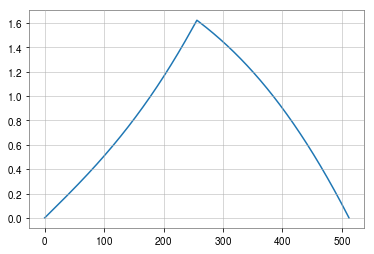

In [123]:
plt.plot(freqs, abs(rfft(filt1)*rfft(filt2)))

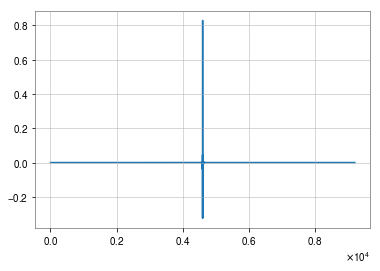

In [121]:
plt.plot(filt12)

In [124]:
sum(filt1**2)

1.0000000000000007

In [127]:
sum(abs(rfft(filt1))**2)/(seglen*srate/2.)

1.0000000000208378